,symbol,share_change,transaction_type,quarter,year,industry,sub_industry
0,CVS,13688600.0,buy,2,2024,Health Care,Health Care Services
7,NSC,1771700.0,buy,2,2024,Industrials,Rail Transportation
14,VFC,3903700.0,buy,2,2024,Consumer Discretionary,"Apparel, Accessories & Luxury Goods"
21,JCI,3423647.0,buy,2,2024,Industrials,Building Products
28,AVTR,2092100.0,buy,2,2024,Health Care,None
...,...,...,...,...,...,...,...
5563,CXO,10965200.0,sell,1,2021,NaN,NaN
5564,NOV,10804666.0,sell,1,2021,Energy,Oil & Gas Equipment & Services
5571,AZN,1261073.0,sell,1,2021,Health Care,Pharmaceuticals
5927,MAT,7070522.0,sell,4,2020,Consumer Discretionary,Leisure Products


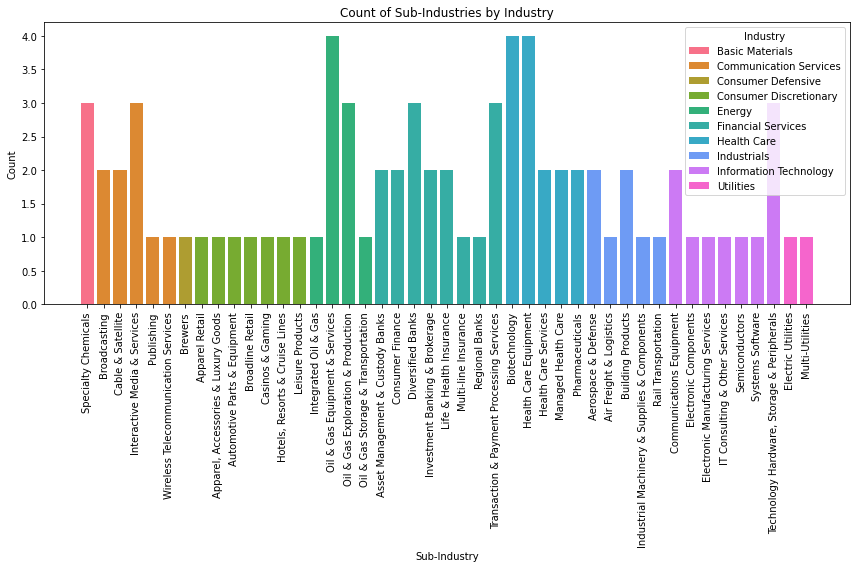

In [10]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

def read_db_credentials(file_path):
    credentials = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            credentials[key] = value
    return credentials

def get_fund_activity(fund_code):
    file_path = 'DB_connection.txt'
    credentials = read_db_credentials(file_path)
    connection_string = f"postgresql+psycopg2://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database']}"
    engine = create_engine(connection_string)
    
    query_activity = f"""
    SELECT a.symbol, a.share_change, a.transaction_type, a.quarter, a.year
    FROM activity a
    WHERE a.fund_code = '{fund_code}'
    """
    
    query_industries = """
    SELECT c.symbol, c.industry, c.sub_industry
    FROM companies c
    """
    
    df_activity = pd.read_sql(query_activity, engine)
    df_industries = pd.read_sql(query_industries, engine)
    df_combined = pd.merge(df_activity, df_industries, on='symbol', how='left')
    df_unique_symbols = df_combined.drop_duplicates(subset='symbol')

    return df_unique_symbols

fund_code = 'DODGX'  # Introduce the company symbol here
df_fund_activity = get_fund_activity(fund_code)

display(df_fund_activity)

def plot_industry_subindustry_counts(df):
    industry_counts = df.groupby(['industry', 'sub_industry']).size().reset_index(name='counts')

    industries = industry_counts['industry'].unique()
    palette = sns.color_palette("husl", len(industries))
    color_map = dict(zip(industries, palette))

    plt.figure(figsize=(12, 8))
    for industry in industries:
        industry_data = industry_counts[industry_counts['industry'] == industry]
        plt.bar(industry_data['sub_industry'], industry_data['counts'], color=color_map[industry], label=industry)

    plt.title('Count of Sub-Industries by Industry')
    plt.xlabel('Sub-Industry')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.legend(title='Industry')
    plt.tight_layout()
    plt.savefig('Sub-industries by industry.jpg')
    plt.show()

plot_industry_subindustry_counts(df_fund_activity)